In [2]:
import numpy as np
import itertools
import matplotlib.pyplot as plt
import cv2
import rad_target_detection as rtd
import tkinter as tk
from tkinter.filedialog import askopenfilenames
import os

# RAD Target detection Algorithm

This notebook shows our algorithm for rad target detection step by step.
you can find the implementation of the main functions we are using in the file rad_target_detection.py

## Load image
Please load image with rad targets

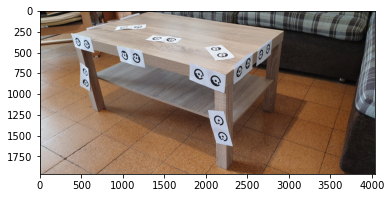

In [3]:
# Load image with file dialog
start = os.getcwd()
root = tk.Tk()
filename = tk.filedialog.askopenfilenames(title='Select Input File')
root.destroy()
filename = os.path.relpath(filename[0],start)
image = cv2.imread(filename)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # rgb image
rgb_img = image.copy()
plt.imshow(rgb_img)
plt.show()

## Thresholding
To get robastic thresholding for diffrent lighting conditions and diffrents scenes and qualities
we are using adaptive thresholding and bilatiral filter.

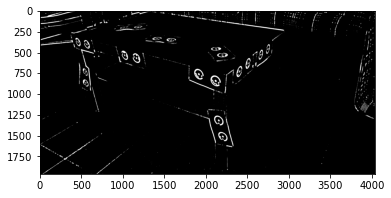

In [4]:
# firstly we will threshold the image to make it binary
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)  # gray image for thresholding
binary_img = rtd.binarize_image(gray,d=20, sig1=150, sig2=150, b_size=25, c=5)

plt.imshow(binary_img, cmap='gray')
plt.show()

## Find Contours

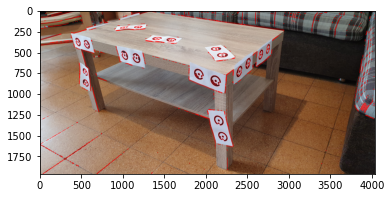

In [10]:
# getting contours of the binary image
contour_thresh=10

contours = rtd.contour_image(binary_img, contour_thresh)
c_img = rgb_img.copy()
cv2.drawContours(c_img, contours, -1, (255, 0, 0), 2)
plt.imshow(c_img)
plt.show()

## Find convex hulls and fitting ellipses

[INFO] fitting ellipses to contours
[INFO] found 591 valid ellipses


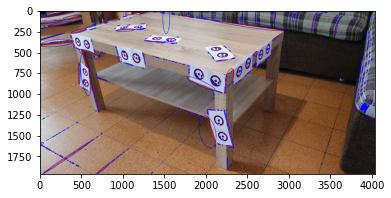

In [11]:
# next step is to fit ellipses to the contours and filter out ones that cannot be candidates for target
ellipses, hulls = rtd.find_ellipses(contours)
for i, ellip in enumerate(ellipses):
    rtd.draw_ellipse(c_img, ellip[0], ellip[1], ellip[2], 0, 360, (0, 0, 255))
plt.imshow(c_img)
plt.show()

## Filter the targets from the ellipses
We are looking for ccouples of concentric ellipses that has the right ratio to be rad targets 

In [12]:
# find concentric ellipses, check to see if ratio applies between each pair of concentric ellipses
rad_targets = rtd.find_rad_targets(ellipses, lower_thresh=3.5, upper_thresh=7.5)

100%|██████████| 174345/174345 [00:03<00:00, 45796.80it/s][INFO] found 20 suspected as RAD targets



## Targets encoding

In [13]:
# coding each target by it's shape
targets_df = rtd.targets_encoding(binary_img, rad_targets)

[INFO] for target center (395.0, 1829.0) the coding is 111111111111
[INFO] for target center (2201.0, 1509.0) the coding is 101000000000
[INFO] for target center (2152.0, 1316.0) the coding is 100000000000
[INFO] for target center (550.0, 865.0) the coding is 101110010000
[INFO] for target center (2114.0, 840.0) the coding is 101111000000
[INFO] for target center (1912.0, 760.0) the coding is 100111000000
[INFO] for target center (543.0, 734.0) - NOT A TARGET
[INFO] for target center (2399.0, 728.0) the coding is 100010110000
[INFO] for target center (2504.0, 630.0) the coding is 101010110000
[INFO] for target center (1160.0, 567.0) the coding is 100101100000
[INFO] for target center (2197.0, 529.0) the coding is 100110100000
[INFO] for target center (1019.0, 532.0) the coding is 101101100000
[INFO] for target center (2658.0, 525.0) the coding is 101000100000
[INFO] for target center (2119.0, 455.0) the coding is 101110100000
[INFO] for target center (2744.0, 456.0) the coding is 10000

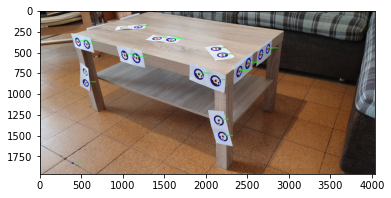

In [14]:
# drawing found targets on img
t_img = rgb_img.copy()
rtd.draw_targets(t_img, targets_df)
plt.imshow(t_img)
plt.show()